In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors.kde import KernelDensity

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

sys.path.append('Modules')

import read_data

In [2]:
def get_range(data):
    low, high = data.min(), data.max()
    dist = (high-low)
    
    return low - dist*.02, high+dist*.02

def do_violin(data, ax):
    xvals = np.linspace(data.min(), data.max(), 120)
    step = (data.max()-data.min()) / 20
    
    kde = KernelDensity(kernel='gaussian', bandwidth=step).fit(data[:,np.newaxis])
    log_dens = np.exp(kde.score_samples(xvals[:,np.newaxis]))
    log_dens = log_dens / log_dens.max()
    
    xlow, xhigh = get_range(data)
    log_dens = log_dens * (xhigh-xlow) * .98 + xlow
    
    ax.fill_between(xvals, xlow, log_dens, linewidth=.5, facecolor='#FFAAAA', edgecolor='#000000')
    ax.axis([xlow, xhigh, xlow, xhigh])
    
    return

def manage_column(column):
    labels = column.split()
    labels = [' '.join(labels[i:i+1]) for i in range(0,len(labels),2)]
    
    return '\n'.join(labels)

def manage_columns(df):
    columns = [r'V$_{resting}$ (mv)',
               r'R$_{input}$ (mΩ)',
               'C (pF)',
               'AP threshold (pA)',
               'AP symmetry',
               'AP amplitude (mV)',
               'AP halfwidth (ms)',
               r'dF/dI$_{step}$(Hz/pA)',
               'Attenuation',
               'Sag (mV)'
              ]
    df.columns = columns
    
    return

In [3]:
df_ephys = read_data.read_ephys_data(age_cutoff=20)
df_labels = read_data.read_dataset_labels('Lab_Pvalb')
df_labels = df_labels.loc[df_ephys.index,:]
df_ref = pd.read_csv('References/marker_ref.txt', sep='\t', header=0, index_col=0)
manage_columns(df_ephys)

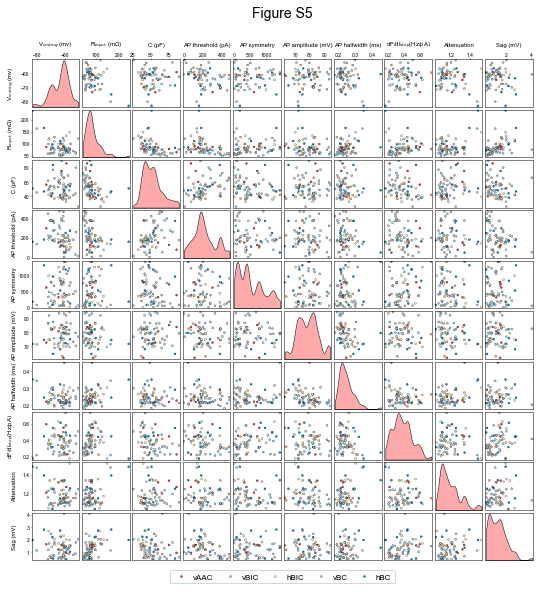

In [4]:
size = 8.5,11
fig = plt.figure(figsize=size)
fig.suptitle('Figure S5', y=.93, fontsize=14)

Width = .66/size[0]
Height = .66/size[1]
dW = .04 / size[0]
dH = .04 / size[1]
Left = .77/size[0]
Top = (size[1]-1.5)/size[1]
Bottom = Top - Height

cell_colors = df_ref.loc[df_labels.CellType, 'Face']

for colnum, (ephys_col, data_col) in enumerate(df_ephys.iteritems()):
    for rownum, (ephys_row, data_row) in enumerate(df_ephys.iteritems()):
        ax = fig.add_axes([Left+(Width+dW)*colnum, Bottom-(Height+dH)*rownum, Width, Height])
        if colnum == 0:
            ax.set_ylabel(ephys_row, fontsize=6)
            ax.yaxis.set_label_coords(-.3, .5)
        elif colnum == 9 and False:
            ax.set_ylabel(ephys_row, fontsize=6)
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
        else:
            ax.set_yticks([])
        if rownum == 0:
            ax.set_title(ephys_col, fontsize=6)
            ax.xaxis.tick_top()
        elif rownum == 9 and False:
            ax.set_xlabel(ephys_col, fontsize=6)
        else:
            ax.set_xticks([])
        
        if colnum == rownum:
            do_violin(data_col, ax)
            #ax.set_yticks([])
        else:
            ax.scatter(data_col, data_row, facecolor=cell_colors, edgecolor='#000000', s=4, linewidth=.25)
            ax.set_xlim(*get_range(data_col))
            ax.set_ylim(*get_range(data_row))
        ax.tick_params(labelsize=5, size=1, pad=1)

ax = fig.add_axes([0.4, 0.20, 0.2, 0.02], frame_on=False)
ax.set_xticks([]), ax.set_yticks([])
        
fname = 'References/marker_ref.txt'
df_marker = pd.read_csv(fname, sep='\t', header=0, index_col=0)

args = ([0], [0])
celltypes = ['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC']
kwargs = {'marker':'o', 'markeredgewidth':.25, 'markersize':2, 'color':'w'}
patches = [Line2D(*args, label=label,
                  markerfacecolor=df_marker.loc[label, 'Face'],
                  markeredgecolor=df_marker.loc[label, 'Edge'], 
                  **kwargs
                 ) for label in celltypes]

kwargs = {'fontsize':8,
          'ncol':5,
          'loc':'center',
          'columnspacing':1,
          'handletextpad':.5
         }
ax.legend(patches, celltypes, **kwargs)

fig.savefig('Figures/Figure S5.pdf')
plt.show()